## Geometric distribution

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geom, chisquare

In [97]:
p = 0.3
U = np.random.uniform(size=10000)
X = np.floor(np.log(U) / np.log(1 - p)) + 1

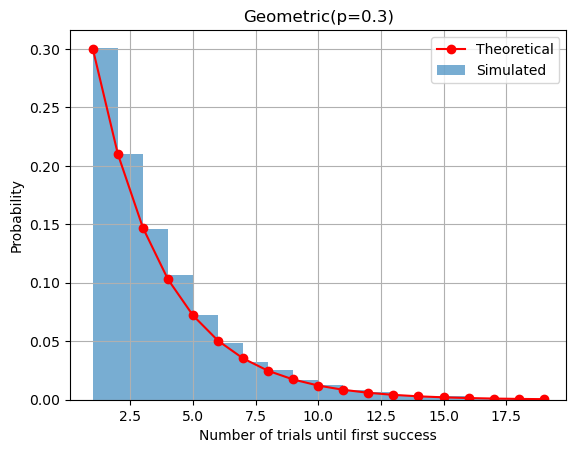

In [98]:
plt.hist(X, bins=range(1, 20), density=True, alpha=0.6, label='Simulated')
x = np.arange(1, 20)
plt.plot(x, geom.pmf(x, p), 'o-', label='Theoretical', color='red')
plt.xlabel('Number of trials until first success')
plt.ylabel('Probability')
plt.title(f'Geometric(p={p})')
plt.legend()
plt.grid(True)
plt.show()


## 6-point distribution

### Direct (crude) method

In [99]:
# define probabilities and CDF
p = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])

def cdf(probabilities):
    cdf = []
    total = 0
    for prob in probabilities:
        total += prob
        cdf.append(total)
    return cdf

cdf_p = cdf(p)

print(cdf_p)


[0.14583333333333334, 0.25, 0.375, 0.4375, 0.6875, 1.0]


In [100]:
def direct_method_sample():
    U = np.random.uniform()
    # find the first index where U <= cdf
    for i, threshold in enumerate(cdf_p):
        if U <= threshold:
            return i + 1  # because X values start at 1

In [101]:
# simulate 10 000 samples
samples_crude = [direct_method_sample() for _ in range(10000)]

### Rejection sampling

In [102]:
k = len(p)
c = max(p)  # c >= max p_i

def rejection_sample():
    while True:
        U1, U2 = np.random.uniform(size=2)
        I = int(np.floor(k * U1)) + 1 
        if U2 <= p[I - 1] / c:
            return I

In [103]:
# simulate 10 000 samples
samples_rejection = [rejection_sample() for _ in range(10000)]

### Alias method

In [104]:
def alias_setup(p, eps=1e-10):
    k = len(p)
    L = np.arange(k)  
    F = k * p.copy()
    
    G = list(np.where(F >= 1)[0])  # indices where F >= 1 
    S = list(np.where(F <= 1)[0])  # indices where F <= 1 
    
    while len(S) > 0:
        i = G[0]     
        j = S[0]  

        L[j] = i    

        F[i] = F[i] - (1 - F[j]) 

        if F[i] < 1 - eps:
            # remove i from front of G
            G.pop(0)
            # append i to end of S
            S.append(i)
        else:
            pass

        # remove j from the front of S
        S.pop(0)

    return L, F

def alias_sample(L, F):
    k = len(F)
    U1, U2 = np.random.uniform(size=2)
    I = int(np.floor(k * U1)) + 1 

    # adjust indices for zero-based Python arrays
    i = I - 1

    if U2 <= F[i]:
        return I  
    else:
        return L[i] + 1  # output alias L[i], convert to 1-based

In [105]:
# setup alias tables
L, F = alias_setup(p)

samples_alias = [alias_sample(L, F) for _ in range(10000)]

### Comparison of the three methods

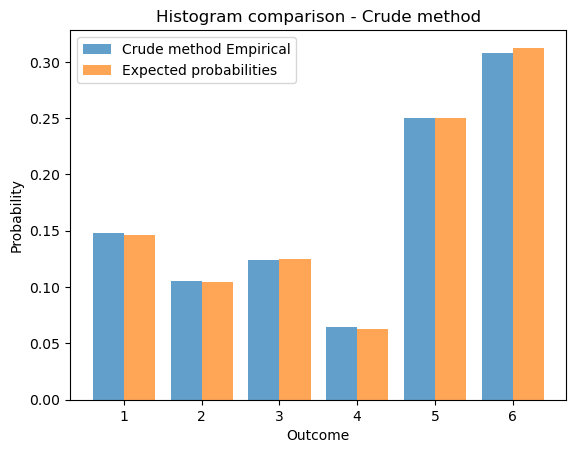

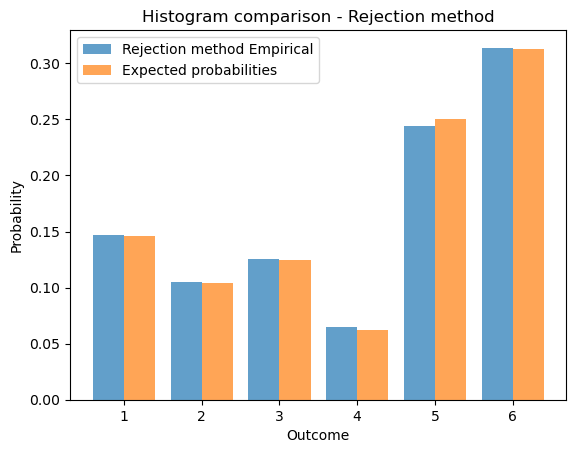

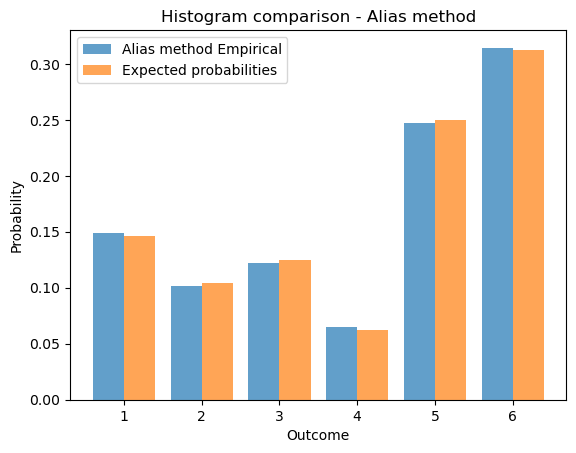

In [108]:
values = np.arange(1, len(p) + 1)

def plot_hist(samples, method_name):
    counts = [sum(np.array(samples) == v) for v in values]
    empirical_probs = np.array(counts) / len(samples)
    
    plt.bar(values - 0.2, empirical_probs, width=0.4, label=f'{method_name} Empirical', alpha=0.7)
    plt.bar(values + 0.2, p, width=0.4, label='Expected probabilities', alpha=0.7)
    plt.xticks(values)
    plt.xlabel('Outcome')
    plt.ylabel('Probability')
    plt.title(f'Histogram comparison - {method_name}')
    plt.legend()
    plt.show()

plot_hist(samples_crude, 'Crude method')
plot_hist(samples_rejection, 'Rejection method')
plot_hist(samples_alias, 'Alias method')

In [107]:
def chi_squared_test(samples, p):
    counts = np.array([sum(np.array(samples) == v) for v in values])
    expected_counts = p * len(samples)
    stat, p_value = chisquare(f_obs=counts, f_exp=expected_counts)
    return stat, p_value

for name, samples in [('Crude', samples_crude),  ('Rejection', samples_rejection), ('Alias', samples_alias)]:
    stat, p_val = chi_squared_test(samples, p)
    print(f"{name} method: Chi-squared statistic = {stat:.4f}, p-value = {p_val:.4f}")


Crude method: Chi-squared statistic = 1.6961, p-value = 0.8894
Rejection method: Chi-squared statistic = 2.5441, p-value = 0.7698
Alias method: Chi-squared statistic = 3.7258, p-value = 0.5895
